# Setting the OpenAI Key as an Environment Variable

In [1]:
%load_ext dotenv
%dotenv

# Importing Relevant Classes and functions

In [2]:
# Library Import
from langgraph.graph import START, END, StateGraph, add_messages
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from typing import Optional
from IPython.display import clear_output

# Define State

In [3]:
# Define State 
class SQLState(TypedDict):
    max_query_limit: int
    user_question: Optional[str]

    business_intent: Optional[str]
    metrics: Optional[str]
    filters: Optional[str]

    schema_context: Optional[str]
    generated_sql: Optional[str]

    another_question: Optional[str]

    valid_sql: Optional[str]

    no_of_queries: int

# Define Chat Model

In [4]:
# Define Chat Model
chat = ChatOpenAI(model='gpt-4',
                  seed= 25,
                  max_completion_tokens= 300,
                  temperature=0
)

# Node Creations

## 1.  schema_content node

In [5]:
# schema defination node
def schema_content(state: SQLState) -> dict:
    schema = '''
    Table: Sales
    Columns:
    1. order_id (int)
    2. order_date (date)
    3. region (string)
    4. revenue (float)
    '''

    return {'schema_context': schema}

## 2. ask_query node

In [6]:
# ask_query node
def ask_query(state: SQLState) -> dict:
    print('Enter your query')
    question = input()

    return {'user_question': question}

## 3. intent_extractor node

In [7]:
# intent_extractor node
def intent_extractor(state: SQLState) -> dict:
    prompt = f'''
    Extract the business intent, metrics and filter from the below user quesion:

    Question:
    {state['user_question']}

    return in below JSON format
    {{
        "business_intent": "...."
        "metrics": [.....]
        "filters": "...."
    '''
    
    AI_response = chat.invoke([
        SystemMessage(content="You are a business analytics expert"),
        HumanMessage(content=prompt)
    ])

    data = eval(AI_response.content)

    return data

## 4. generate_sql node

In [8]:
# generate_sql node
def generate_sql(state: SQLState) -> dict:
    sql_prompt = f'''
    You are a SQL Expert.

    Schema:
    {state['schema_context']}

    Business Intent: 
    {state['business_intent']}
    
    Metrics:
    {state['metrics']}
    
    Filters: 
    {state['filters']}

    Rules:
    - Use SELECT only
    - No DELETE / UPDATE / DROP
    - Use explicit column names

    Generate SQL only.
    '''

    generated_sql_response = chat.invoke([
        SystemMessage(content='Generate an optimised SQL query'),
        HumanMessage(content=sql_prompt)
    ])

    query = state['no_of_queries'] + 1
    
    return {
        'generated_sql': generated_sql_response.content.strip(),
        'no_of_queries': query
    }
    

## 5. validate_sql node

In [9]:
# Validate_sql node
def validate_sql(state: SQLState) -> dict:
    sql = state['generated_sql'].upper()
    
    if any(word in sql for word in ['DELETE', 'DROP', 'TRUNCATE']):
        return {'valid_sql': 'invalid'}
    if 'SALES' not in sql:
        return {'valid_sql': 'invalid'}
    else:
        return {'valid_sql': 'valid'}

## 6. corrected_sql node

In [10]:
# corrected_sql node
def corrected_sql(state: SQLState) -> dict:
    sql_prompt = f'''
    You are a SQL Expert.

    Schema:
    {state['schema_context']}

    Business Intent: 
    {state['business_intent']}
    
    Metrics:
    {state['metrics']}
    
    Filters: 
    {state['filters']}

    Generated SQL Query:
    {state['generated_sql']}

    Fix the SQL. Return only the corrected SQL
    '''

    generated_sql_response = chat.invoke([
        SystemMessage(content=f"Fix SQL code without any 'DELETE', 'DROP', 'TRUNCATE' statement."),
        HumanMessage(content=sql_prompt)
    ])

    query = state['no_of_queries']
    
    return {
        'generated_sql': generated_sql_response.content.strip(),
        'no_of_queries': query
    }
    

## 7. show_state node

In [11]:
# show_state node
def show_state(state: SQLState) -> None:
    clear_output()
    valid_status = state['valid_sql']
    status = ""
    
    if valid_status == 'valid':
        status = f"✅ Your SQL Query is successfully validated."
    else:
        status = f"❌ Your SQL Query didn't pass the validation."
        
    show_state = f'''
    =============================User Question=============================
    {state['user_question']}
    
    =============================Generated_SQL=============================:
    {state['generated_sql']}

    =============================No. of Query Count=============================:
    {state['no_of_queries']}

    =============================Query Validation Status=============================:
    {status}
    '''
    print(show_state)

## 8. ask_another_query node

In [12]:
# ask_another_query node
def ask_another_query(state: SQLState) -> dict:
    print("Would you like to enter another query (yes/no)")
    humanResponse = input().lower()

    return {'another_question': humanResponse}

# Routing Functions

## routing_another_question_function function

In [13]:
# routing_another_question_function function
def routing_another_question_function(state: SQLState) -> str:
    another_query = state['another_question']
    query_limit = state['no_of_queries']
    max_limit = state['max_query_limit']
    
    if another_query == 'yes' and query_limit < max_limit:
        return 'True'
    else:
        print('You choose to exit or you exceeded the number of queries')
        return 'False'

## routing_validate_function function

In [14]:
# routing_validate_function function
def routing_validate_function(state: SQLState) -> str:
    valid_status = state['valid_sql']
    
    if valid_status == 'valid':
        print(f"✅ Your SQL Query is successfully validated.")
        return 'True'
    else:
        print(f"❌ Your SQL Query didn't pass the validation.")
        return 'False'

## Graph Creation

In [16]:
# Graph creation
graph = StateGraph(SQLState)

# Node Creations
graph.add_node('schema_content', schema_content)
graph.add_node('ask_query', ask_query)
graph.add_node('intent_extractor', intent_extractor)
graph.add_node('generate_sql', generate_sql)
graph.add_node('validate_sql', validate_sql)
graph.add_node('corrected_sql', corrected_sql)
graph.add_node('show_state', show_state)
graph.add_node('ask_another_query', ask_another_query)

# Edge Creation
graph.add_edge(START, 'schema_content')
graph.add_edge('schema_content', 'ask_query')
graph.add_edge('ask_query', 'intent_extractor')
graph.add_edge('intent_extractor', 'generate_sql')
graph.add_edge('generate_sql', 'validate_sql')
graph.add_conditional_edges(source='validate_sql', path=routing_validate_function, path_map={
    'False': 'corrected_sql',
    'True': 'show_state'
})
graph.add_edge('corrected_sql','validate_sql')
graph.add_edge('show_state', 'ask_another_query')
graph.add_conditional_edges(source='ask_another_query', path=routing_another_question_function, path_map={
    'True': 'ask_query',
    'False': '__end__'
})

# Compiling the graph
graph_compiled = graph.compile()

In [17]:
response = graph_compiled.invoke({
    "no_of_queries": 0,
    "max_query_limit": 2
})



    =============================User Question=============================
    Show monthly revenue for last quarter

    =============================Generated_SQL=============================:
    SELECT 
    EXTRACT(YEAR FROM order_date) AS Year,
    EXTRACT(MONTH FROM order_date) AS Month,
    SUM(revenue) AS Monthly_Revenue
FROM 
    Sales
WHERE 
    order_date >= DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 quarter'
    AND order_date < DATE_TRUNC('quarter', CURRENT_DATE)
GROUP BY 
    Year, Month
ORDER BY 
    Year, Month;

    =============================No. of Query Count=============================:
    1

    =============================Query Validation Status=============================:
    ✅ Your SQL Query is successfully validated.
    
Would you like to enter another query (yes/no)


 no


You choose to exit or you exceeded the number of queries


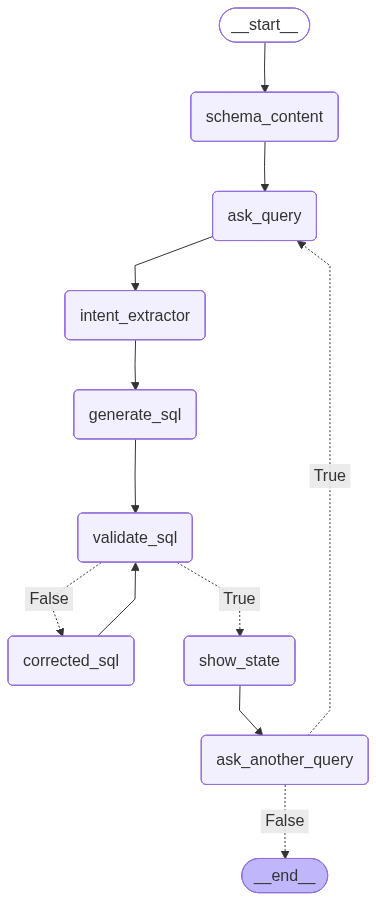

In [18]:
graph_compiled